In [8]:
from clustertools import build_datacube
from matplotlib import pyplot as plt 
import numpy as np

In [9]:
datacube = build_datacube("segpc-unet-baseline")
datacube.metrics

['repr',
 'save_path',
 'threshold',
 'thresholds',
 'train_losses',
 'val_dice',
 'val_losses',
 'val_metrics',
 'val_soft_dice']

In [10]:
baseline_dice = datacube("val_dice")
baseline_roc = datacube("val_metrics")

bl_dice_avg, bl_dice_std = np.mean(baseline_dice, axis=0).squeeze(), np.std(baseline_dice, axis=0).squeeze()
bl_roc_avg, bl_roc_std = np.mean(baseline_roc, axis=0).squeeze(), np.std(baseline_roc, axis=0).squeeze()


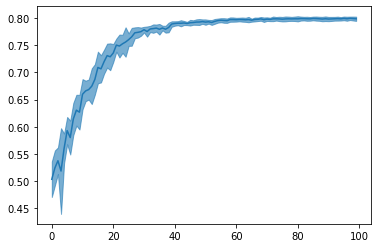

In [15]:
from monuseg_params_and_scores_compare import plt_with_std, COLORS
plt.figure()
plt_with_std(plt.gca(), np.arange(100), bl_dice_avg, bl_dice_std, label="baseline", color=COLORS[0])
plt.show()

In [35]:
print('dice best avg:', np.max(bl_dice_avg))
print('dice best roc:', np.max(bl_roc_avg))

dice best avg: 0.7995510512763889
dice best roc: 0.9764925428501399


In [16]:
ic = datacube(rseed=0)

last_model_path = ic('save_path')[-1]
last_model_path


'1645499562.7788_e_99_val_0.1351_roc_0.9759_z0_s512.pth'

In [17]:
import os
import torch
from unet import Unet

In [18]:
model_path = os.path.join('/home/rmormont/models/segpc-unet/weights', last_model_path)

In [19]:
device = torch.device("cuda:0")
unet = Unet(int(ic.metadata["init_fmaps"]), n_classes=1)
unet.load_state_dict(torch.load(model_path))
unet.to(device)
unet.eval()


Unet(
  (conv1): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True

In [20]:
from segpc import SegpcDatasetGenerator
from dataset import predict_roi
from augment import get_aug_transforms, get_norm_transform

In [21]:
dataset = SegpcDatasetGenerator("/scratch/users/rmormont/segpc", 512, missing_seed=42, remove_ratio=0.0, n_complete=298, n_calibrate=0)

In [22]:
incomplete_list, complete_list, val_set_list, calibration_list = dataset.sets()

In [23]:
y_pred, y_true = predict_roi(
    val_set_list[0], dataset.val_roi_foreground(val_set_list[0]), unet, device,
    in_trans=get_norm_transform(), batch_size=8,
    tile_size=512, overlap=0, n_jobs=1, zoom_level=0
)

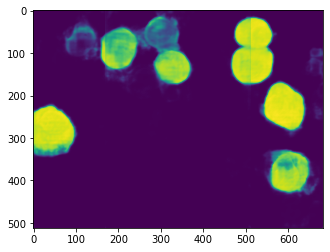

In [24]:
plt.imshow(y_pred)

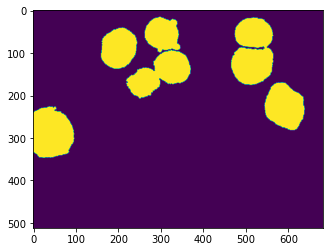

In [25]:
plt.imshow(y_true)

In [26]:
from sklearn.metrics import roc_auc_score
from threshold_optimizer import Thresholdable, thresh_exhaustive_eval

In [27]:
print("roc", roc_auc_score(y_true.flatten(), y_pred.flatten()))
th_opt = Thresholdable(y_true.flatten(), y_pred.flatten())
thresholds, dices = thresh_exhaustive_eval(th_opt, eps=0.01)
best_idx = np.argmax(dices)
threshold, dice = thresholds[best_idx], dices[best_idx]
print("thresh", threshold)
print("dice", dice)

roc 0.9775778513310168
thresh 0.22021329402923584
dice 0.8379129135965867


In [28]:
y_pred, y_true = predict_roi(
    val_set_list[1], dataset.val_roi_foreground(val_set_list[1]), unet, device,
    in_trans=get_norm_transform(), batch_size=8,
    tile_size=512, overlap=0, n_jobs=1, zoom_level=0
)

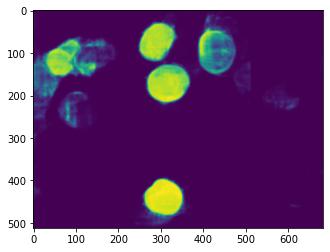

In [29]:
plt.imshow(y_pred)

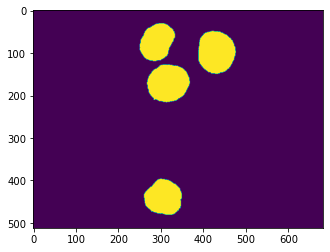

In [30]:
plt.imshow(y_true)

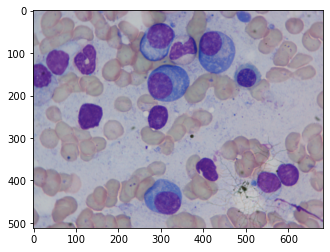

In [31]:
plt.imshow(val_set_list[1].crop_and_mask()[0])

In [32]:
print("roc", roc_auc_score(y_true.flatten(), y_pred.flatten()))
th_opt = Thresholdable(y_true.flatten(), y_pred.flatten())
thresholds, dices = thresh_exhaustive_eval(th_opt, eps=0.01)
best_idx = np.argmax(dices)
threshold, dice = thresholds[best_idx], dices[best_idx]
print("thresh", threshold)
print("dice", dice)

roc 0.9908558766864217
thresh 0.39039550721645355
dice 0.7933174398076774
